# Gendist
## Zero-shot on trenches

In [2]:
%cd ../gendist/experiments
%load_ext autoreload
%autoreload 2

/home/gerardoduran/documents/shift-happens/gendist/experiments


In [3]:
import jax
import gendist
import optax
import torchvision
import numpy as np
import mnist_rotation_meta as metaexp
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA

In [39]:
%config InlineBackend.figure_format = "retina"

In [4]:
def predict_shifted_dataset(ix_seed, X_batch, processor, config, wmodel, wparams, dmodel, proj, fn_reconstruct):
    """
    Parameters
    ----------
    ix_seed: array
    X_batch: array
    ...
    wmodel: model for the latent space
    wparams: trained weights for the latent space
    dmodel: model for the observed space
    dparams: trained model for the observed weights
    """
    x_seed = X_batch[ix]
    x_shift = processor.process_single(x_seed, **config).ravel()
    predicted_weights = wmodel.apply(wparams, x_shift)
    predicted_weights = proj.inverse_transform(predicted_weights)
    predicted_weights = fn_reconstruct(predicted_weights)
    
    X_batch_shift = processor(X_batch, config)
    y_batch_hat = dmodel.apply(predicted_weights, X_batch_shift)
    
    return y_batch_hat

In [5]:
filename_data_model = "../../outputs/2203221129/output/data-model-result.pkl"
path_experiment = "../../outputs/2203221129/"

In [6]:
output = metaexp.load_train_combo(filename_data_model)
target_params = output["params"]
list_configs = output["configs"]
fn_reconstruct_params = output["fn_reconstruct"]

In [7]:
processing_class = gendist.processing.Factory(metaexp.rotate)
key = jax.random.PRNGKey(314)
key, key_subset = jax.random.split(key)

In [8]:
n_components = 50
n_classes = 10
n_train_subset = 6_000
n_configs = len(list_configs)

In [9]:
mnist_train = torchvision.datasets.MNIST(root=".", train=True, download=True)
X_train = np.array(mnist_train.data) / 255
X_train = metaexp.configure_covariates(key_subset, metaexp.processing_class, X_train, list_configs, n_train_subset)

n_train, *elem_dims = X_train.shape

tcmalloc: large alloc 5644804096 bytes == 0x55d5fe3c8000 @  0x7efd35f2b680 0x7efd35f4c824 0x7efd146771ed 0x7efd14677267 0x7efd146b9c1b 0x7efd146b9ed8 0x7efd1476b177 0x7efd1476cdec 0x7efd148b2652 0x55d536521e88 0x55d5366a35d8 0x7efd14773ff7 0x55d53660f520 0x55d53664a568 0x55d5366048c3 0x55d53657c1ca 0x55d536603b32 0x55d5366b3ddc 0x55d536604b5b 0x55d5366e98fe 0x55d5365e2581 0x55d53657c3be 0x55d5365f4d34 0x55d53664e3ff 0x55d5365f4d34 0x55d53664e3ff 0x55d5365f4d34 0x55d5365fe0a3 0x55d53657c1a4 0x55d5366048c3 0x55d53657c3be
tcmalloc: large alloc 2822406144 bytes == 0x55d7eff92000 @  0x7efd35f2b680 0x7efd35f4c824 0x7efd146771ed 0x7efd14677267 0x7efd146b9c1b 0x7efd14756b5e 0x7efd1475737a 0x7efd147575ae 0x55d5365c3e64 0x55d5365bd7e4 0x7efd146a6a74 0x55d5365c3e88 0x55d5365bde4f 0x55d536649937 0x55d536603b32 0x55d536604697 0x55d53657bf00 0x55d5366048c3 0x55d53657c1a4 0x55d536603b32 0x55d536604697 0x55d5365f460a 0x55d5365f49d5 0x55d5365bde4f 0x55d536649937 0x55d5366048c3 0x55d53657c1ca 0x55d53660

In [10]:
subset_configs = list_configs[::3]
subset_target_params = target_params[::3]
X_train_subset = X_train[:, ::3, :]

In [11]:
pca = PCA(n_components=n_components)
projected_params = pca.fit_transform(subset_target_params)[None, ...]

In [12]:
alpha = 0.01
n_epochs = 150
batch_size = 2000
tx = optax.adam(learning_rate=alpha)
lossfn = gendist.training.make_multi_output_loss_func
meta_model = gendist.models.MLPWeightsV1(n_components)
trainer = gendist.training.TrainingMeta(meta_model, lossfn, tx)

In [13]:
meta_output = trainer.fit(key, X_train_subset, projected_params, n_epochs, batch_size)

  0%|          | 0/150 [00:00<?, ?it/s]

# Testing model

`7, 2, 1, 0, 4`

In [14]:
import os
from loguru import logger
from datetime import datetime

In [15]:
data_model = gendist.models.MLPDataV1(10)

In [16]:
mnist_test = torchvision.datasets.MNIST(root=".", train=False, download=True)
X_test = np.array(mnist_test.data) / 255
y_test = np.array(mnist_test.targets)

In [17]:
# now_str = datetime.now().strftime("%Y%m%d%H%M")
# file_log = f"trench_test_{now_str}.log"

file_log = "trench_test_202203241311.log"
path_logger = os.path.join(path_experiment, "logs", file_log)
logger.add(path_logger, rotation="5mb")

1

In [18]:
accuracy_configs_learned = []
ixs = np.arange(5)

for config in tqdm(list_configs[123:]):
    acc_dict = {}
    for ix in ixs:
        y_test_hat = predict_shifted_dataset(ix, X_test, metaexp.processing_class, config,
                                             meta_model, meta_output["params"],
                                             data_model, pca, fn_reconstruct_params)
        y_test_hat = y_test_hat.argmax(axis=1)
        accuracy_learned = (y_test_hat == y_test).mean().item()
        acc_dict[ix] = accuracy_learned
        
    accuracy_configs_learned.append(acc_dict)
    
    angle = config["angle"]
    logger_row = "|".join([format(v, "0.2%") for v in acc_dict.values()])
    logger_row = f"{angle=:0.4f} | " + logger_row 
    
    logger.info(logger_row)


  0%|          | 0/27 [00:00<?, ?it/s]

2022-03-24 15:14:24.163 | INFO     | __main__:<cell line: 4>:20 - angle=297.1812 | 97.38%|77.63%|96.74%|97.26%|96.98%
2022-03-24 15:15:04.429 | INFO     | __main__:<cell line: 4>:20 - angle=299.5973 | 82.59%|25.88%|91.26%|78.35%|40.28%
2022-03-24 15:15:44.609 | INFO     | __main__:<cell line: 4>:20 - angle=302.0134 | 95.82%|26.79%|89.16%|93.39%|83.70%
2022-03-24 15:16:24.589 | INFO     | __main__:<cell line: 4>:20 - angle=304.4295 | 97.87%|50.93%|97.90%|97.69%|97.31%
2022-03-24 15:17:04.492 | INFO     | __main__:<cell line: 4>:20 - angle=306.8456 | 94.04%|25.23%|97.44%|50.91%|51.91%
2022-03-24 15:17:44.965 | INFO     | __main__:<cell line: 4>:20 - angle=309.2617 | 93.61%|30.79%|97.26%|85.92%|93.98%
2022-03-24 15:18:24.769 | INFO     | __main__:<cell line: 4>:20 - angle=311.6779 | 97.87%|43.09%|96.88%|98.05%|97.16%
https://symbolize.stripped_domain/r/?trace=7efd35d9fa65,7efd35da13bf&map= 
*** SIGTERM received by PID 3174669 (TID 3174669) on cpu 95 from PID 3169072; stack trace: ***
PC: 

In [ ]:
path_logger

In [ ]:
import re
with open("projection-accuracy-trenches.log", "r") as f:
    logs = f.read()
    
regexp = re.compile(r"radius=([0-9\.]+) \| accuracy_learned=([0-9\.]+)")

log_vals = []
for line in logs.split("\n")[:-1]:
    rad = regexp.search(line)[1]
    acc = regexp.search(line)[2]
    log_vals.append({"radius": float(rad), "accuracy": float(acc)})

log_df = pd.DataFrame(log_vals).set_index("radius")
log_df.plot()
plt.axvline(x=1.0, c="tab:gray", linestyle="--")
plt.axvline(x=2.0, c="tab:gray", linestyle="--")
plt.title("One-shot weight-prediction")

In [70]:
!tree ../../outputs

../../outputs
├── 2203221129
│   ├── logs
│   │   ├── trench_test_202203231830.log
│   │   └── trench_test_202203241311.log
│   └── output
│       ├── data-model-result.pkl
│       ├── meta-model-result.pkl
│       └── meta-model.pkl
├── 2203232215
│   ├── logs
│   └── output
│       └── data-model-result.pkl
├── 2203232259
│   ├── logs
│   └── output
│       └── data-model-result.pkl
├── 2203232346
│   ├── logs
│   └── output
│       └── data-model-result.pkl
├── 2203240033
│   ├── logs
│   └── output
│       └── data-model-result.pkl
├── 2203240119
│   ├── logs
│   └── output
│       └── data-model-result.pkl
├── 2203240206
│   ├── logs
│   └── output
│       └── data-model-result.pkl
├── 2203240253
│   ├── logs
│   └── output
│       └── data-model-result.pkl
├── 2203240341
│   ├── logs
│   └── output
│       └── data-model-result.pkl
├── 2203240428
│   ├── logs
│   └── output
│       └── data-model-result.pkl
└── 2203240516
    ├── logs
    └── output
        └── data-model-result.

## Plotting results

In [103]:
import re
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

In [29]:
path_full_logs = "../../outputs/2203221129/logs/trench_test_202203231830.log"
path_trench_logs = "../../outputs/2203221129/logs/trench_test_202203241311.log"

In [46]:
with open(path_full_logs, "r") as f:
    logs = f.read()

regexp_angle = re.compile(r"angle=([0-9\.]+)")
regexp_acc = re.compile(r"([0-9\.]+)%")


digits = [7, 2, 1, 0, 4]
rows = []
for line in logs.split("\n")[:-1]:
    accuracies = regexp_acc.findall(line)
    angle, *_ = regexp_angle.findall(line)
    
    row_data = {digit: float(val) / 100 for digit, val in zip(digits,  accuracies)}
    row_data["angle"] = float(angle)
    
    rows.append(row_data)

In [47]:
logs_full = pd.DataFrame(rows).set_index("angle")

In [45]:
logs_trench = pd.DataFrame(rows).set_index("angle")

In [ ]:
col = 7

In [110]:
test_col["full"].mean()

0.9746079999999994

In [109]:
test_col["trench"].mean()

0.9261490000000001

<AxesSubplot:ylabel='Proportion'>

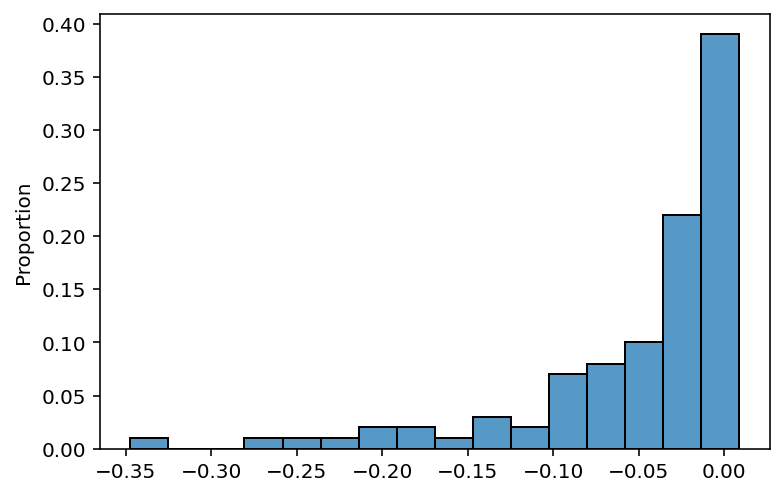

In [107]:
sns.histplot(test_col["trench"] - test_col["full"], stat="proportion")

In [102]:
(test_col["trench"] - test_col["full"]).abs().mean()

0.04870900000000001

In [116]:
logs_full.index[::3]

Float64Index([     0.0,   7.2483,  14.4966,   21.745,  28.9933,  36.2416,
               43.4899,  50.7383,  57.9866,  65.2349,  72.4832,  79.7315,
               86.9799,  94.2282, 101.4765, 108.7248, 115.9732, 123.2215,
              130.4698, 137.7181, 144.9664, 152.2148, 159.4631, 166.7114,
              173.9597, 181.2081, 188.4564, 195.7047,  202.953, 210.2013,
              217.4497,  224.698, 231.9463, 239.1946,  246.443, 253.6913,
              260.9396, 268.1879, 275.4362, 282.6846, 289.9329, 297.1812,
              304.4295, 311.6779, 318.9262, 326.1745, 333.4228, 340.6711,
              347.9195, 355.1678],
             dtype='float64', name='angle')

In [97]:
test_col = pd.DataFrame({"full": logs_full[col], "trench": logs_trench[col]}).drop(logs_full.index[::3])
with pd.option_context("display.max_rows", 100):
    print(test_col)

            full  trench
angle                   
2.4161    0.9816  0.9823
4.8322    0.9762  0.9681
9.6644    0.9785  0.9571
12.0805   0.9675  0.9491
16.9128   0.9749  0.9607
19.3289   0.9792  0.9779
24.1611   0.9674  0.8791
26.5772   0.9742  0.9002
31.4094   0.9779  0.8974
33.8255   0.9788  0.8847
38.6577   0.9767  0.8618
41.0738   0.9786  0.9122
45.9060   0.9684  0.8822
48.3221   0.9726  0.7793
53.1544   0.9789  0.8787
55.5705   0.9782  0.9544
60.4027   0.9672  0.8379
62.8188   0.9772  0.9356
67.6510   0.9712  0.9514
70.0671   0.9762  0.9672
74.8993   0.9783  0.9558
77.3154   0.9740  0.9206
82.1477   0.9690  0.9616
84.5638   0.9707  0.9677
89.3960   0.9819  0.9772
91.8121   0.9819  0.9772
96.6443   0.9793  0.9584
99.0604   0.9794  0.9671
103.8926  0.9700  0.9598
106.3087  0.9764  0.9546
111.1409  0.9795  0.7617
113.5570  0.9745  0.9718
118.3893  0.9739  0.9654
120.8054  0.9791  0.9663
125.6376  0.9743  0.7791
128.0537  0.9639  0.8429
132.8859  0.9790  0.9673
135.3020  0.9783  0.9729


<AxesSubplot:xlabel='angle'>

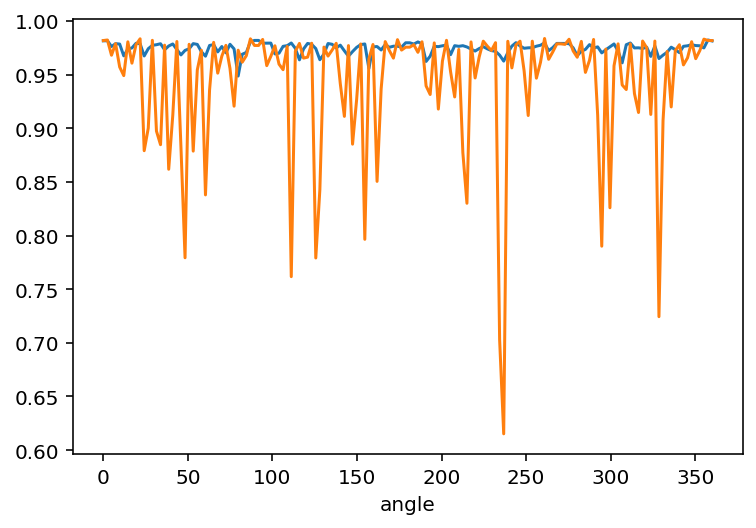

In [59]:
logs_full[col].plot()
logs_trench[col].plot()

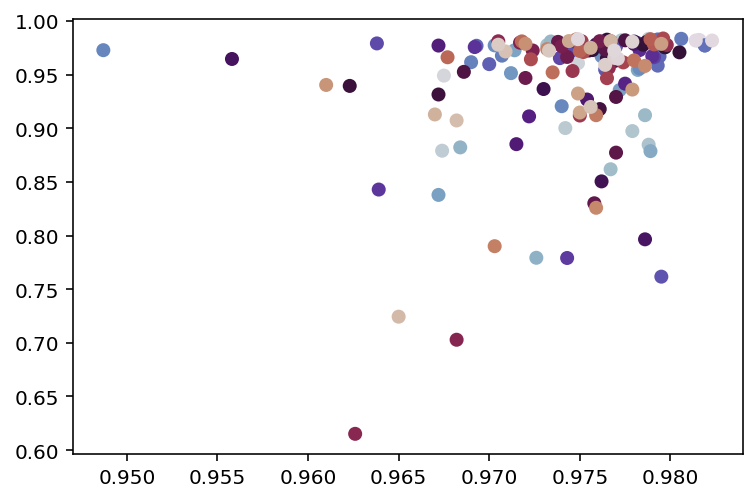

In [73]:
plt.scatter(logs_full[col], logs_trench[col], c=logs_full.index, cmap="twilight")